In [1]:
import matplotlib.pyplot as plt
import numpy as np

from helperTools import *
from KevinBumperClass import swarmShift_x
from storageRingModeler import StorageRingModel,make_optimal_solution_model
from phaseSpaceAnalyzer import SwarmSnapShot
from phaseSpaceAnalysis_Functions import make_phase_space_info,plot_ring_lattice_with_stops,emittance_from_particles

from ParticleClass import Swarm
model=make_optimal_solution_model()

In [2]:
model.mode_match()

(0.6908914842660849, 76.89519332025971)

In [ ]:
# from ParticleTracerLatticeClass import ParticleTracerLattice
# from helperTools import *
# PTL=ParticleTracerLattice(lattice_type='injector')
# PTL.add_drift(.1)
# # PTL.add_drift(.2,input_tilt_angle=0.5,output_tilt_angle=-.5)
# # PTL.add_drift(.1,output_tilt_angle=.1)
# PTL.add_segmented_halbach_bender(.0254,.01,30,1.0)
# # PTL.add_bender_ideal(np.pi/10.0,1.0,1.0,.01)
# # PTL.add_drift(.1)
# # PTL.add_combiner_sim_lens(.2,.02)
# PTL.end_lattice()
#
# PTL.show_lattice()


In [92]:
from math import cos,sin,atan,tan,pi
def convert_center_to_orbit_coords(el,s: float, xc: float, yc: float) -> tuple[float, float, float]:
    """Convert center coordinates [s,xc,yc] to cartesian coordinates[x,y,z]"""
    arc_length=el.ang*el.ro
    if 0.0 <= s < el.L_cap:
        x, y, z = el.ro + xc, s - el.L_cap, yc
    elif el.L_cap <= s < el.L_cap + arc_length:
        theta = (s - el.L_cap) / el.ro
        r = el.ro + xc
        x, y, z = cos(theta) * r, sin(theta) * r, yc
    elif el.L_cap + arc_length <= s <= arc_length + 2 * el.L_cap:
        theta = el.ang
        r = el.ro + xc
        x0, y0 = cos(theta) * r, sin(theta) * r
        delta_s = s - (el.ang * el.ro + el.L_cap)
        theta_perp = pi + atan(-1 / tan(theta))
        x, y, z = x0 + cos(theta_perp) * delta_s, y0 + sin(theta_perp) * delta_s, yc
    else:
        raise ValueError
    return x, y, z


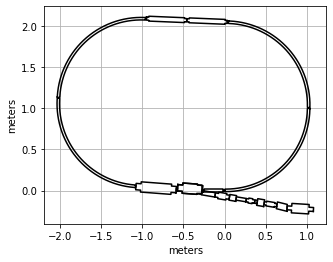

In [117]:
from latticeElements.combiner_characterizer import  make_halbach_combiner_force_function,compute_particle_trajectory
from latticeElements.elements import Drift,HalbachLensSim,CombinerHalbachLensSim,BenderIdeal,HalbachBenderSimSegmented
from shapely.geometry import LineString
def combiner_Halbach_xy(el):
    atomState = 'HIGH_FIELD_SEEKER' if el.field_fact == -1 else 'LOW_FIELD_SEEKER'
    force_Func = make_halbach_combiner_force_function(el)
    qArr, _ = compute_particle_trajectory(force_Func, el.PTL.speed_nominal, 0.0, 2 * el.space + el.Lm,
                                          particle_y_offset_start=el.output_offset, atom_state=atomState)
    xy=qArr[:,:2]
    for i,coord in enumerate(xy):
        xy[i]=el.R_Out@coord
    xy+=el.r2[:2]
    return xy

def straight_xy(el):
    xy=np.array([[0.0,0.0],[el.L,0.0]])
    for i,coord in enumerate(xy):
        xy[i]=el.R_Out@coord
    xy+=el.r1[:2]
    return xy

def ideal_bend_xy(el):
    angles=np.linspace(0.0,el.ang)
    xy=np.column_stack((el.ro*np.cos(angles),el.ro*np.sin(angles)))
    for i,coord in enumerate(xy):
        xy[i]=el.R_Out@coord
    xy+=el.r0[:2]
    return xy

def segmented_halbach_bender(el):
    s_vals=np.linspace(1e-6,el.Lo-1e-6)
    xy=np.array([convert_center_to_orbit_coords(el,s,0.0,0.0)[:2] for s in s_vals])
    for i,coord in enumerate(xy):
        xy[i]=el.R_Out@coord
    xy+=el.r0[:2]
    return xy

def make_Particle_Trajectory(el):
    if type(el) in (Drift,HalbachLensSim):
        xy=straight_xy(el)
    elif type(el) is CombinerHalbachLensSim:
        xy=combiner_Halbach_xy(el)
    elif type(el) is BenderIdeal:
        xy=ideal_bend_xy(el)
    elif type(el) is HalbachBenderSimSegmented:
        xy=segmented_halbach_bender(el)
    else:
        raise NotImplemented
    # xy_plot_format=list(xy.T)
    # return xy_plot_format
    return xy
def make_trajectory_shape(el):
    xy=make_Particle_Trajectory(el)
    return LineString(xy)


# %matplotlib inline
# model.lattice_ring.show_lattice(show_immediately=False,plot_outer=True)
# for el in model.lattice_ring.el_list:
#     plt.plot(*make_Particle_Trajectory(el),c='red',linestyle=':')
# plt.show()
model.show_floor_plan()


In [135]:
from shapely.affinity import rotate, translate
import copy
def injector_shapes_in_ring_frame(model, shapes):
    ne_Inj, ne_Ring = model.lattice_injector.combiner.ne, model.lattice_ring.combiner.ne
    angle_injector = full_arctan2(ne_Inj[1], ne_Inj[0])
    angle_ring = full_arctan2(ne_Ring[1], ne_Ring[0])
    rotation_angle = angle_ring - angle_injector
    r2_injector = model.lattice_injector.combiner.r2
    r2_ring = model.lattice_ring.combiner.r2
    shapes_lab_frame=[]
    for shape in shapes:
        shape=copy.copy(shape)
        shape = translate(shape, xoff=-r2_injector[0], yoff=-r2_injector[1])
        shape = rotate(shape, rotation_angle, use_radians=True, origin=(0, 0))
        shape = translate(shape, xoff=r2_ring[0], yoff=r2_ring[1])
        shapes_lab_frame.append(shape)
    return shapes_lab_frame

In [141]:
def make_shapes(lattice):
    shapes_outer=[el.SO_outer for el in lattice]
    shapes_inner=[el.SO for el in lattice]
    shapes_trajectories=[make_trajectory_shape(el) for el in lattice]
    return shapes_inner,shapes_outer,shapes_trajectories
def make_injector_shapes_ring_frame(model):
    shapes_sequence=list(make_shapes(model.lattice_injector))
    for i,shapes in enumerate(shapes_sequence):
        shapes_sequence[i]=injector_shapes_in_ring_frame(model,shapes)
    return shapes_sequence


In [144]:
%matplotlib tk


shapes_inner,shapes_outer,shapes_trajectories=make_shapes(model.lattice_ring)
shapes_system=(make_shapes(model.lattice_ring),make_injector_shapes_ring_frame(model))
for [shapes_inner,shapes_outer,shapes_trajectories] in shapes_system:
    for shape in shapes_inner:
        plt.plot(*shape.exterior.xy,c='black',linestyle=':')
    for shape in shapes_outer:
        plt.plot(*shape.exterior.xy,c='black')
    for shape in shapes_trajectories:
        plt.plot(*shape.xy,c='red',linestyle=':')

# shapes.extend(model.injector_shapes_in_lab_frame(whichSide))
plt.gca().set_aspect('equal')
plt.show()